In [ ]:
from tensorflow.keras.datasets import mnist
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [ ]:
X_train = torch.tensor(X_train / 255).to(torch.float32)
X_test = torch.tensor(X_test / 255).to(torch.float32)

In [ ]:
def train(X, model, loss_fn, optim, batch_size):
  for i in range(len(X) // batch_size):
    indices = np.random.choice(range(len(X)), batch_size, replace=False)
    model.train()
    pred = model(X[indices])
    loss = loss_fn(pred, X[indices])
    loss.backward()
    optim.step()
    optim.zero_grad()

In [ ]:
def evaluate(X, model, loss_fn, size, epoch):
  model.eval()
  pred = model(X)
  loss = loss_fn(pred, X).item()
  print(f"Epoch: {epoch} Loss: {round(loss, 4)}")
  fig, axis = plt.subplots(1, size, figsize=(size * 1.5, 1.5))
  for img, ax in zip(pred.detach()[:size], axis):
    ax.imshow(img.reshape(28, 28), cmap="binary")
    ax.set_xticks([])
    ax.set_yticks([])
  plt.show()

In [ ]:
def plot(X):
  fig, axis = plt.subplots(1, 10, figsize=(15, 1.5))
  for img, ax in zip(X, axis):
    ax.imshow(img.reshape(28, 28), cmap="binary")
    ax.set_xticks([])
    ax.set_yticks([])
  plt.show()

# AutoEncoder

In [ ]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Linear(784, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 32),
        nn.ReLU(),
    )
    self.decoder = nn.Sequential(
        nn.Linear(32, 256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512, 784),
        nn.Sigmoid()
    )

  def forward(self, X):
    self.encoded = self.encoder(X)
    self.decoded = self.decoder(self.encoded)
    return self.decoded

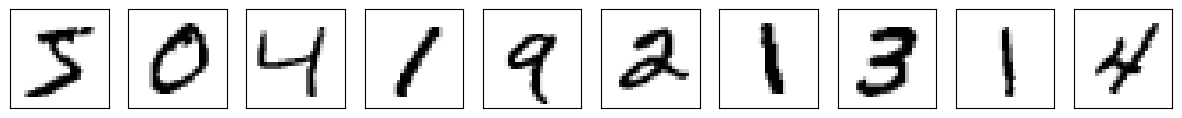

In [ ]:
plot(X_train[:10])

In [ ]:
model = AutoEncoder()
loss_fn = nn.BCELoss()
optim = torch.optim.Adam(model.parameters())

Epoch: 1 Loss: 0.1298


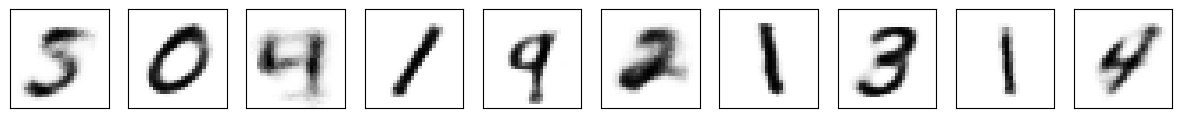

Epoch: 11 Loss: 0.0836


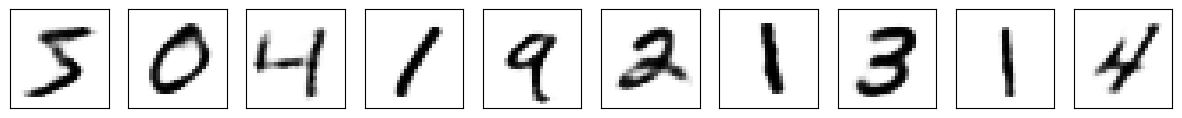

Epoch: 21 Loss: 0.081


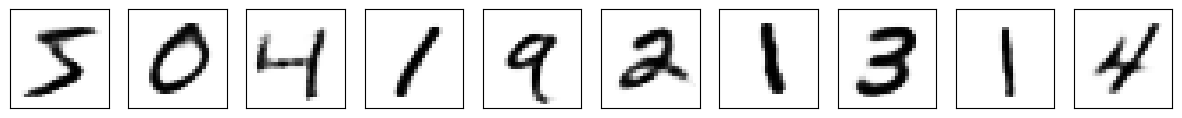

Epoch: 31 Loss: 0.0791


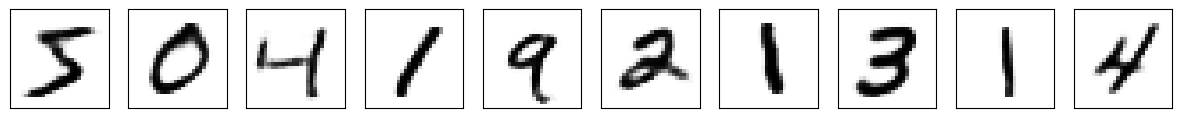

Epoch: 41 Loss: 0.0784


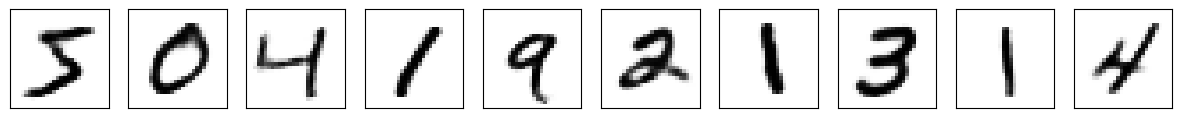

Epoch: 51 Loss: 0.078


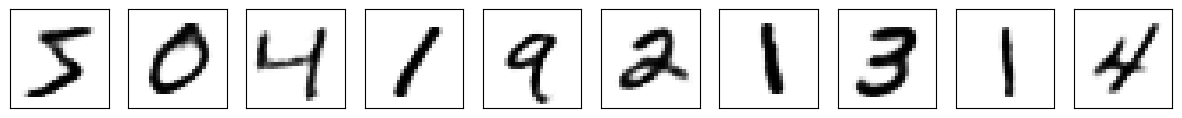

In [ ]:
for i in range(51):
  train(X_train.reshape(60000, 784), model, loss_fn, optim, 100)
  if i % 10 == 0:
    evaluate(X_train.reshape(60000, 784), model, loss_fn, 10, i + 1)

Testing autoencoder on test data

In [ ]:
test_pred = model(X_test[:10].reshape(10, 784))

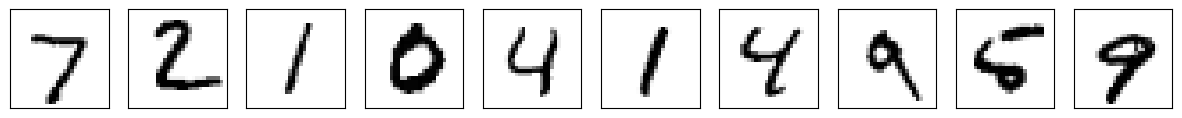

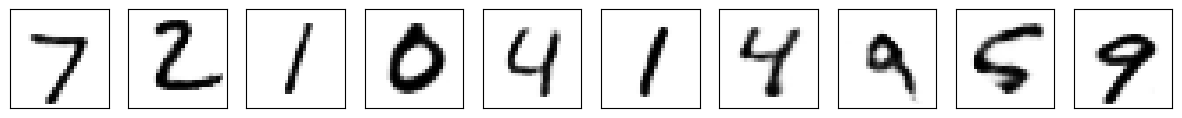

In [ ]:
plot(X_test[:10])
plot(test_pred.detach())

Generating images from random latent variables

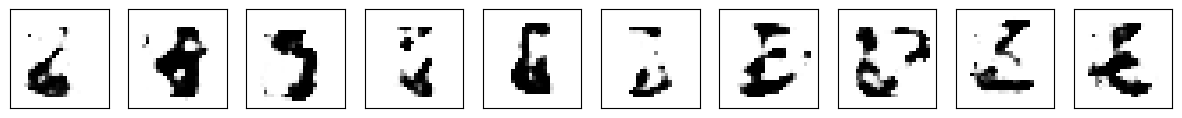

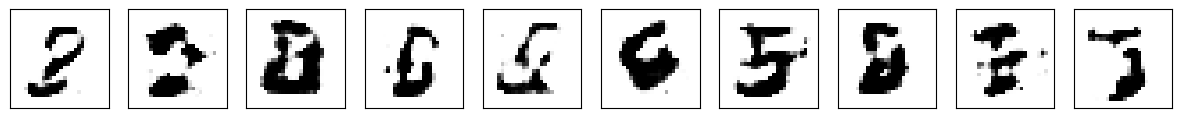

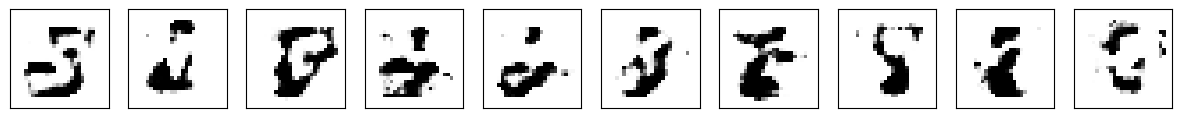

In [ ]:
for i in range(3):
  random_latent_variables = torch.tensor([np.random.uniform(0, 16, 32) for i in range(10)]).to(torch.float32)
  generated_images = model.decoder(random_latent_variables)
  plot(generated_images.detach())

# Variational AutoEncoder

In [ ]:
class CustomLoss(nn.Module):
  def __init__(self):
    super(CustomLoss, self).__init__()
    self.BCE_Loss = nn.BCELoss()
    self.KL_Loss = nn.KLDivLoss()

  def forward(self, predictions, target):
    return torch.mean(self.BCE_Loss(predictions, target) + self.KL_Loss(predictions, target)) # !!

In [ ]:
class Normal(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, means, spreads):
        return torch.normal(means, spreads)

In [ ]:
class VAE(nn.Module):
  def __init__(self):
    super().__init__()
    self.seq1 = nn.Sequential(
        nn.Linear(784, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
    )

    self.means = nn.Sequential(nn.Linear(256, 32), nn.ReLU())
    self.spreads = nn.Sequential(nn.Linear(256, 32), nn.ReLU())
    self.generate_from_normal = Normal()

    self.decoder = nn.Sequential(
        nn.Linear(32, 256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512, 784),
        nn.Sigmoid()
    )

  def forward(self, X):
    self.seq = self.seq1(X)
    self.generated_from_normal = self.generate_from_normal(self.means(self.seq), self.spreads(self.seq))
    self.decoded = self.decoder(self.generated_from_normal)
    return self.decoded

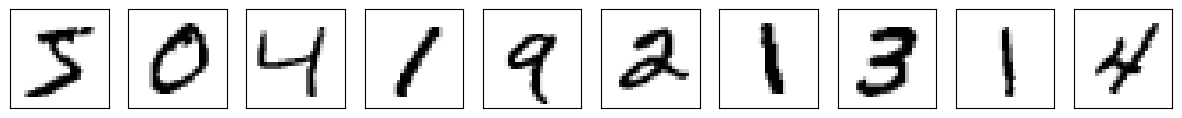

In [ ]:
plot(X_train[:10])

In [ ]:
model = VAE()
loss_fn = nn.BCELoss()
optim = torch.optim.Adam(model.parameters())

Epoch: 1 Loss: 0.224


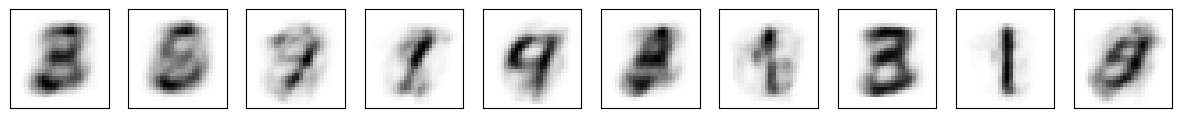

Epoch: 11 Loss: 0.193


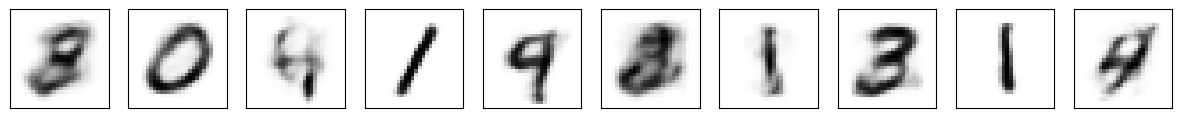

Epoch: 21 Loss: 0.1888


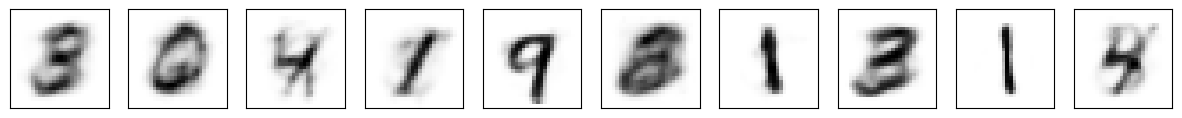

Epoch: 31 Loss: 0.1864


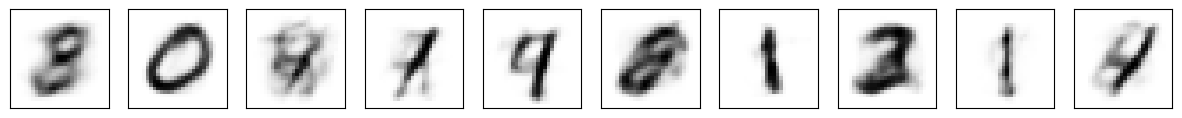

Epoch: 41 Loss: 0.1857


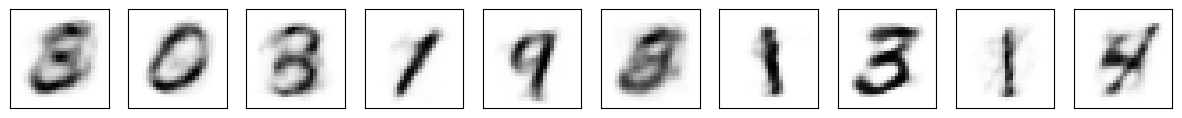

Epoch: 51 Loss: 0.1845


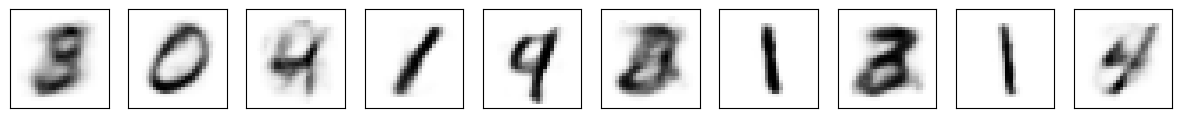

In [ ]:
for i in range(101):
  train(X_train.reshape(60000, 784), model, loss_fn, optim, 100)
  if i % 10 == 0:
    evaluate(X_train.reshape(60000, 784), model, loss_fn, 10, i + 1)

Epoch: 101 Loss: 0.1783


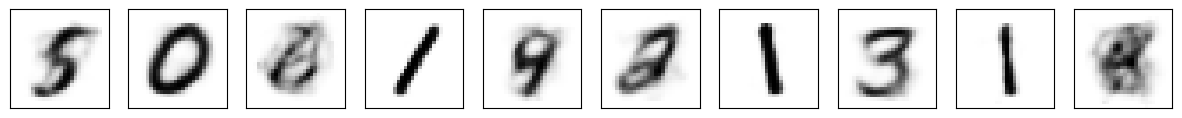

Epoch: 111 Loss: 0.1778


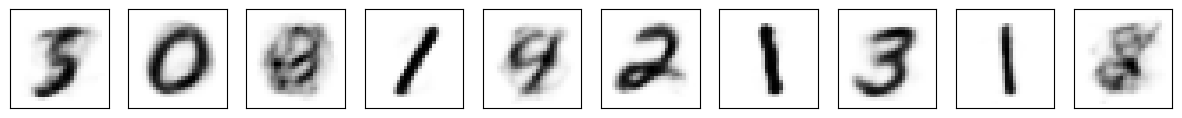

Epoch: 121 Loss: 0.1772


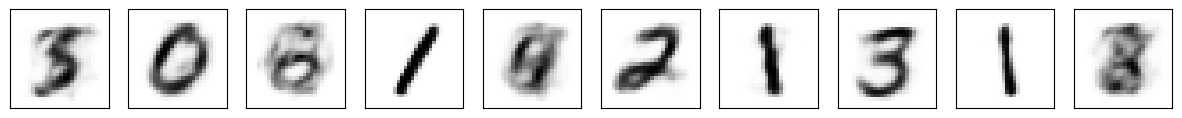

Epoch: 131 Loss: 0.1766


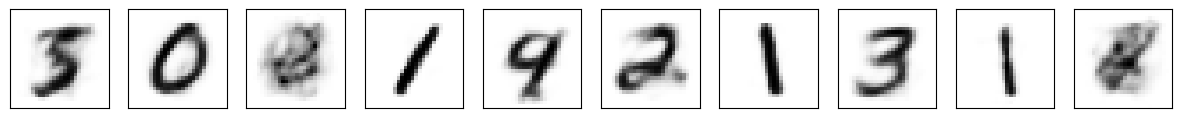

Epoch: 141 Loss: 0.1763


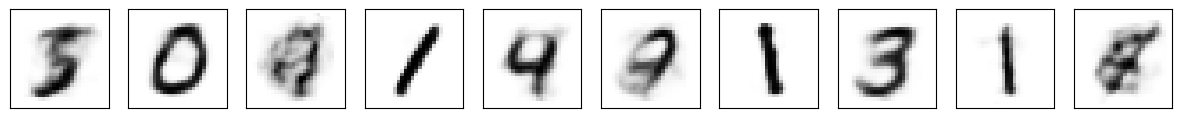

Epoch: 151 Loss: 0.1758


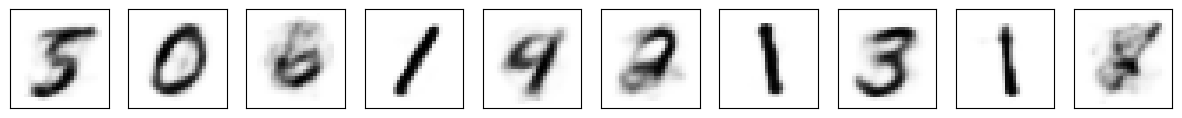

Epoch: 161 Loss: 0.1753


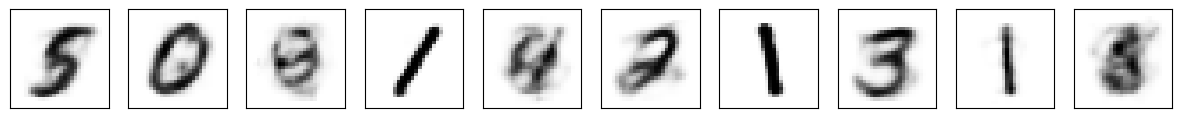

Epoch: 171 Loss: 0.1753


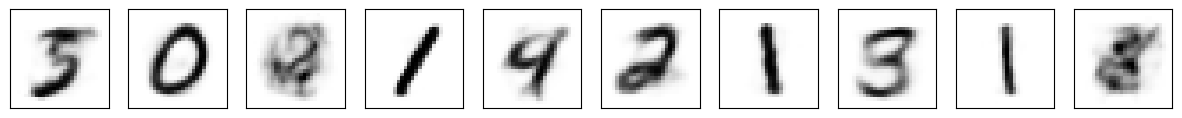

Epoch: 181 Loss: 0.1748


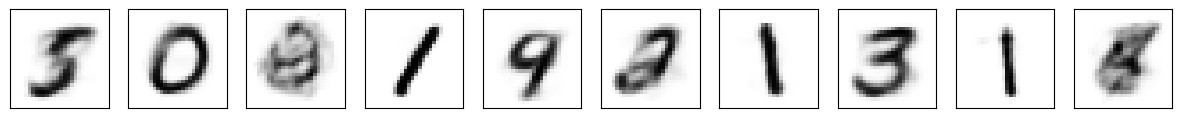

Epoch: 191 Loss: 0.1748


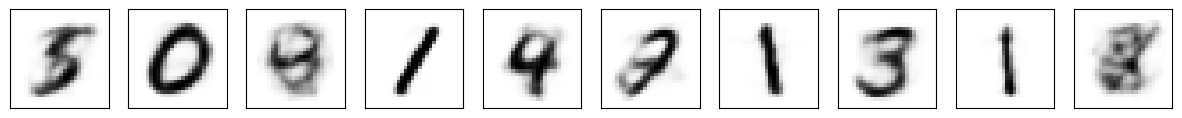

In [ ]:
for i in range(101):
  train(X_train.reshape(60000, 784), model, loss_fn, optim, 100)
  if i % 10 == 0:
    evaluate(X_train.reshape(60000, 784), model, loss_fn, 10, i + 101)

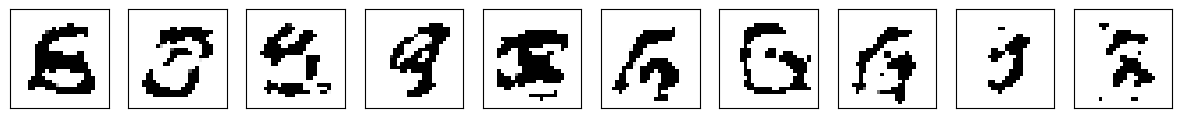

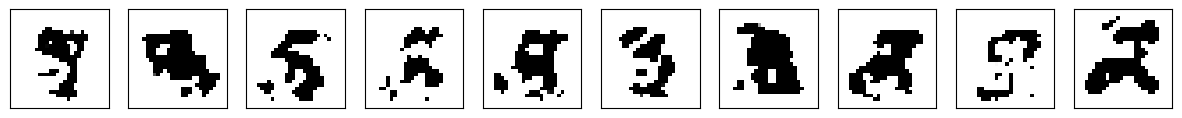

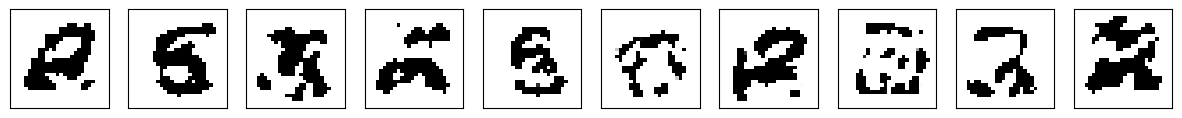

In [ ]:
for i in range(3):
  random_latent_spreads = torch.tensor([np.random.uniform(0, 0.226, 32) for i in range(10)]).to(torch.float32)
  random_latent_means = torch.tensor([np.random.uniform(0, 0.183, 32) for i in range(10)]).to(torch.float32)
  generated_images = model.decoder(model.generate_from_normal(random_latent_means, random_latent_variables))
  plot(generated_images.detach())

While it underfits, it generates images that resemble MNIST numbers a lot more than original autoencoder